# Определение стоимости автомобилей

**Постановка задачи**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**План работ:**

-  Открыть файл и изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
- Подготовить выборки для обучения моделей.
- Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
- Проанализировать время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

## Подготовка данных

Импортируем необходимые библиотеки.

In [1]:
# установка библиотеки category_encoders
!pip install category_encoders

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from category_encoders import MEstimateEncoder
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor


In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('/datasets/autos.csv')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df.info() # Выведем основную информацию о датафрейме df_0 с помощью метода info().

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В таблице 16 столбцов и 354369 строки. Типы данных в столбцах — int64(7), object(9). Количество значений в столбцах различается, значит в данных есть пропуски.

Согласно документации к данным:

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**

- Price — цена (евро)


In [7]:
# Сохраним в переменную изначальный размер датасета, чтобы после удаления пропусков посчитать какой % данных в итоге потерян
original_df = df.shape

Изменим названия столбцов. Для удобства работы приведем их к змеиному регистру.

In [8]:
df.columns = df.columns.str.lower() # сначала приводим все столбцы к нижнему регистру 

In [9]:
df.columns # проверяем результат

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [10]:
# приводим необходимые столбцы к змеиному регистру

df = df.rename(columns={'datecrawled':'date_crawled', 'vehicletype':'vehicle_type', 
                        'registrationyear':'registration_year', 'registrationmonth':'registration_month', 
                        'fueltype':'fuel_type', 'datecreated':'date_created',
                        'numberofpictures': 'number_of_pictures','postalcode':'postal_code',
                        'lastseen':'last_seen'})

In [11]:
df.columns # проверяем результат

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [12]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


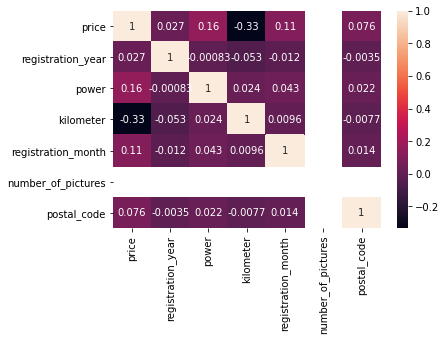

In [13]:
sns.heatmap(df.corr(), annot = True);

Корреляции между столбцами не обнаружено.

Построим общую гистограмму для всех числовых столбцов таблицы. 

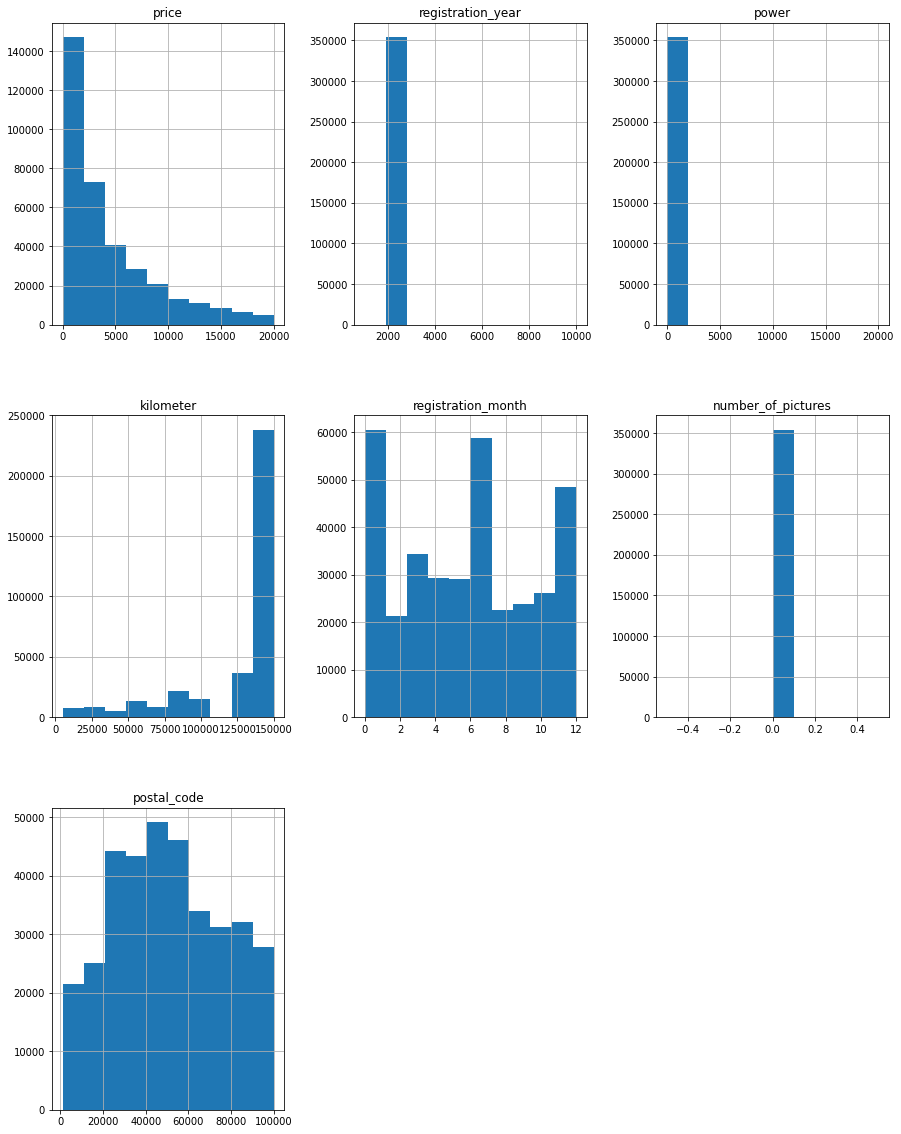

In [14]:
df.hist(figsize=(15,20));

Посчитаем количество пропущенных значений.

In [15]:
df.isnull().sum() # подсчёт пропусков

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Пропущенные значения есть в 5 столбцах. 

**Предобработка данных**

Проверим строки-дубликаты, у которых полностью совпадают значения в ячейках

In [16]:
df.duplicated().sum()

4

In [17]:
# Удалим явные дубликаты
df = df.drop_duplicates().reset_index(drop=True) 
df.duplicated().sum()

0

Рассмотрим столбец price - цена (евро). Это целевая переменная.

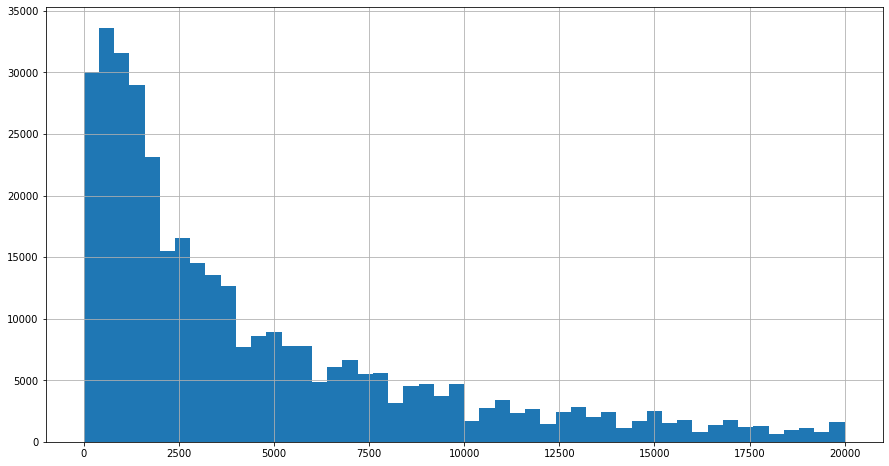

In [18]:
df['price'].hist(bins = 50, figsize=(15,8));

На графике видно, что есть нулевые значения. Скорее всего это те объявления, где не указали в поле цену. Еще есть слишком маленькие цены, возможно ошиблись при заполнении поля. 

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Молодец. Цена == 0 - это без комментариев.

p.s. а цены == 1..2..50..100 евро будешь обрабатывать?
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> А я ниже убрала слишком маленькие цены </font>
</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Да, вижу.
</div>

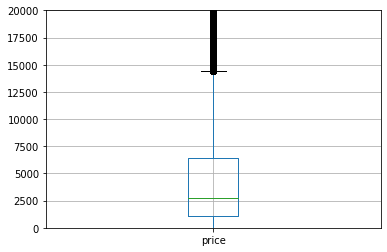

In [19]:
df.boxplot(column=['price'])
plt.ylim(0, 20000);

In [20]:
df = df.loc[df['price']>=100] # удалим нулевые значение и слишком маленькие цены 

In [21]:
df['price'].describe()

count    341051.000000
mean       4588.887026
std        4514.862284
min         100.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

Рассмотрим столбец registration_year — год регистрации автомобиля

In [22]:
df['registration_year'].describe()

count    341051.000000
mean       2003.955335
std          69.812151
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [23]:
df['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222,
       2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500,
       4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 7000, 7100, 7800,
       8200, 8500, 8888, 9000, 9450, 9999])

Максимальный год 9999 - интересно, конечно, а минимальный 1000. Посмотрим на распределение анкет.

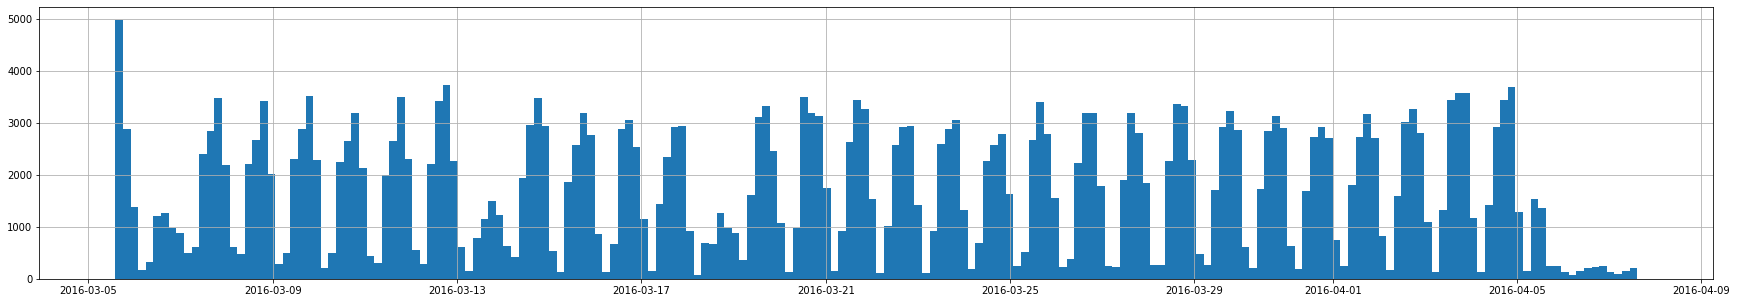

In [24]:
date_form = pd.to_datetime(df['date_crawled'])
date_form.hist(bins = 200, figsize = (30, 5));

In [25]:
# Избавимся от аномальных значений. 

# Минимальный год регистрации оставим 1900 (примерно в это время появились первые машины)
df = df.loc[df['registration_year'] >= 1900]
# Максимальный год регистрации оставим 2016 (актуальный период заполнения анкет)
df = df.loc[df['registration_year'] <= 2016]

In [26]:
df['registration_year'].describe()

count    327321.000000
mean       2002.624766
std           6.860050
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

Неинформативный для нас столбец registration_month удалим, оставим только год регистрации автомобиля.

In [27]:
df = df.drop(['registration_month'], axis=1)

Рассмотрим столбец vehicle_type - тип автомобильного кузова

In [28]:
df['vehicle_type'].isnull().sum() / len(df) * 100 # узнаем процент пропущенных значений в столбце vehicle_type

5.774453823616573

In [29]:
df['vehicle_type'].value_counts() # посмотрим на уникальные значения в столбце vehicle_type

sedan          89083
small          77439
wagon          63460
bus            28263
convertible    19816
coupe          15551
suv            11761
other           3047
Name: vehicle_type, dtype: int64

In [30]:
# Заполнить пропуски достоверными значениями в столбце с типом кузова мы не можем, поэтому заполним их заглушкой
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')
df['vehicle_type'].isnull().sum() 

0

Рассмотрим столбец gearbox — тип коробки передач

In [31]:
df['gearbox'].isnull().sum() / len(df) * 100 # узнаем процент пропущенных значений в столбце gearbox

4.460453194264957

In [32]:
df['gearbox'].value_counts() # посмотрим на уникальные значения в столбце gearbox

manual    249912
auto       62809
Name: gearbox, dtype: int64

In [33]:
# Заполнить пропуски достоверными значениями в столбце с типом коробки передач не можем, поэтому заполним их заглушкой
df['gearbox'] = df['gearbox'].fillna('unknown')
df['gearbox'].isnull().sum() 

0

Рассмотрим столбец power — мощность (л. с.)

In [34]:
df['power'].describe()

count    327321.000000
mean        112.338060
std         185.285633
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

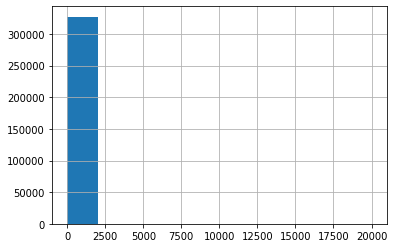

In [35]:
df.power.hist();

На сегодняшний день самый мощный легковой автомобиль с мощностью двигателя - 2000 лошадиных сил. Поэтому удалим нулевые и слишком маленькие значения в столбце 'power', а так же  значения больше 2000.

In [36]:
df = df.loc[(df['power']> 15) & (df['power']<2000)]

In [37]:
df['power'].describe()

count    295307.000000
mean        121.604496
std          62.996197
min          16.000000
25%          76.000000
50%         111.000000
75%         150.000000
max        1999.000000
Name: power, dtype: float64

Рассмотрим столбец model — модель автомобиля

In [38]:
df['model'].isnull().sum() / len(df) * 100 # узнаем процент пропущенных значений в столбце model

3.697846647725926

In [39]:
df['model'].sort_values().unique() # посмотрим на уникальные значения в столбце model

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [40]:
# Заполнить пропуски достоверными значениями в столбце с типом кузова мы не можем, поэтому заполним их заглушкой
df['model'] = df['model'].fillna('unknown')
df['model'].isnull().sum() 

0

Рассмотрим столбец fuel_type — тип топлива

In [41]:
df['fuel_type'].isnull().sum() / len(df) * 100 # узнаем процент пропущенных значений в столбце fuel_type

5.195271361667688

In [42]:
df['fuel_type'].value_counts() # посмотрим на уникальные значения в столбце fuel_type

petrol      186832
gasoline     87644
lpg           4679
cng            481
hybrid         201
other           83
electric        45
Name: fuel_type, dtype: int64

In [43]:
# Заполнить пропуски достоверными значениями в столбце с типом кузова мы не можем, поэтому заполним их заглушкой
df['fuel_type'] = df['fuel_type'].fillna('unknown')
df['fuel_type'].isnull().sum() 

0

Рассмотрим столбец repaired — была машина в ремонте или нет

In [44]:
df['repaired'].value_counts() # посмотрим на уникальные значения в столбце repaired

no     224222
yes     28571
Name: repaired, dtype: int64

In [45]:
df['repaired'].isnull().sum() / len(df) * 100 # узнаем процент пропущенных значений в столбце fuel_type

14.396543258371796

11 % - много для удаления. Заполним пропуск значением "unknown". 
 заполнять признак как yes или no не будем, но заполним его как третье значение - not_filled:

In [46]:
df['repaired'] = df['repaired'].fillna('unknown')

In [47]:
df['repaired'].isnull().sum() 

0

Удалим столбцы date_crawled, date_created, postal_code, last_seen, number_of_pictures (тк там все 0), которые не являются информативными. Даты создания, последнего просмотра (активности) и дата скачивания анкеты, а также количество фотографий автомобиля и почтовый индекс владельца анкеты могут повторяться (не уникальны) и бесполезны с точки зрения построения моделей машинного обучения. 

In [48]:
df = df.drop(['date_crawled', 'date_created', 'postal_code', 'last_seen', 'number_of_pictures'], axis=1)
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354357,5250,unknown,2016,auto,150,159,150000,unknown,alfa_romeo,no
354358,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354362,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354363,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [49]:
# Сбросим индексы после удаления пропусков 
df = df.reset_index(drop=True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295307 entries, 0 to 295306
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              295307 non-null  int64 
 1   vehicle_type       295307 non-null  object
 2   registration_year  295307 non-null  int64 
 3   gearbox            295307 non-null  object
 4   power              295307 non-null  int64 
 5   model              295307 non-null  object
 6   kilometer          295307 non-null  int64 
 7   fuel_type          295307 non-null  object
 8   brand              295307 non-null  object
 9   repaired           295307 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.5+ MB


Посмотрим сколько значений у нас осталось после удаления всех пропусков и аномалий:

In [51]:
f'{df.shape[0] / original_df[0]:.2%}'

'83.33%'

**Вывод**

Предобработку завершили. Изменили названия столбцов, для удобства работы привели их к змеиному регистру. Где возможно было заменили пропуски. Избавились от аномалий. Удалили неинформативные признаки. Удалили дубликаты.

## Обучение моделей

Разобьём данные на тренировочную и тестовую выборки. Доли размеров train/test как 3.

In [52]:
target = df['price']
features = df.drop('price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345) 
print(features_train.shape)
print(features_test.shape)

(221480, 9)
(73827, 9)


Наши данные содержат категориальные признаки. Преобразовать категориальные признаки в численные поможет техника OneHotEncoder. 

In [53]:
# Выберем категориальные признаки для кодирования
categorical_features = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']

In [54]:
categorical_features_mb = ['model', 'brand']

In [55]:
# Выберем численные признаки для кодирования
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features

['registration_year', 'power', 'kilometer']

In [56]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [57]:
encoder_ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train_ohe[categorical_features])

# добавляем закодированные признаки в features_train_ohe
# encoder_ohe.get_feature_names() позволяет получить названия колонок
features_train_ohe[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train_ohe[categorical_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_ohe = features_train_ohe.drop(categorical_features, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же

features_train_ohe[num_features] = scaler.fit_transform(features_train_ohe[num_features])

# смотрим на результат
features_train_ohe.head()

,registration_year,power,model,kilometer,brand,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_unknown,x0_wagon,x1_auto,x1_manual,x1_unknown,x2_cng,x2_electric,x2_gasoline,x2_hybrid,x2_lpg,x2_other,x2_petrol,x2_unknown,x3_no,x3_unknown,x3_yes
171474,-1.045553,-1.209154,polo,0.590404,volkswagen,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
146627,0.791733,-0.452096,swift,-0.090338,suzuki,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
135667,2.016591,0.336506,3er,0.590404,bmw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
160423,0.026197,0.651946,a6,0.590404,audi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
102040,-0.433124,-0.325920,unknown,0.590404,audi,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [58]:
# энкодером, который обучен на тренировочной выборке, кодируем тестовую
features_test_ohe[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_test_ohe[categorical_features])

features_test_ohe = features_test_ohe.drop(categorical_features, axis=1)

# скелером, который обучен на тренировочной выборке, масштабируем тестовую
features_test_ohe[num_features] = scaler.transform(features_test_ohe[num_features])

# смотрим на результат
features_test_ohe.head()

,registration_year,power,model,kilometer,brand,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_unknown,x0_wagon,x1_auto,x1_manual,x1_unknown,x2_cng,x2_electric,x2_gasoline,x2_hybrid,x2_lpg,x2_other,x2_petrol,x2_unknown,x3_no,x3_unknown,x3_yes
244576,0.026197,-0.735993,polo,-0.090338,volkswagen,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
175286,0.791733,0.998931,a4,0.590404,audi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
35875,0.944840,1.235512,passat,-1.315674,volkswagen,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8980,1.097948,1.724445,e_klasse,0.590404,mercedes_benz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
159239,-0.433124,-1.067206,corsa,0.590404,opel,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [59]:
# Создаем экземпляр класса MEstimateEncoder 
encoder_me = MEstimateEncoder(return_df=True)

# Обучаем энкодер на тренировочных данных
encoder_me.fit(features_train_ohe[categorical_features_mb], target_train)

# Применяем энкодер к тренировочным данным
features_train_me = pd.DataFrame(encoder_me.transform(features_train_ohe[categorical_features_mb]), 
                                 columns=encoder_me.get_feature_names_out())

# Применяем энкодер к тестовым данным
features_test_me = pd.DataFrame(encoder_me.transform(features_test_ohe[categorical_features_mb]), 
                                 columns=encoder_me.get_feature_names_out())
# Создаем объект StandardScaler
scaler_me = StandardScaler()

# Применяем масштабирование к тренировочным данным
features_train_me[categorical_features_mb] = scaler_me.fit_transform(features_train_me[categorical_features_mb])

# скелером, который обучен на тренировочной выборке, масштабируем тестовую
features_test_me[categorical_features_mb] = scaler_me.transform(features_test_me[categorical_features_mb])

In [60]:
# смотрим результат
features_train_me.head()

,model,brand
171474,-0.836163,-0.027369
146627,-0.260664,-0.424079
135667,0.209594,1.138606
160423,0.792230,1.233313
102040,-0.438924,1.233313


In [61]:
# смотрим результат
features_test_me.head()

,model,brand
244576,-0.836163,-0.027369
175286,0.553015,1.233313
35875,-0.003395,-0.027369
8980,0.485857,0.952596
159239,-1.120022,-1.187602


In [62]:
features_train_ohe = features_train_ohe.drop(columns = ['brand', 'model'])
features_train_ohe = features_train_ohe.join(features_train_me)
features_train_ohe

,registration_year,power,kilometer,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_unknown,x0_wagon,x1_auto,x1_manual,x1_unknown,x2_cng,x2_electric,x2_gasoline,x2_hybrid,x2_lpg,x2_other,x2_petrol,x2_unknown,x3_no,x3_unknown,x3_yes,model,brand
171474,-1.045553,-1.209154,0.590404,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.836163,-0.027369
146627,0.791733,-0.452096,-0.090338,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.260664,-0.424079
135667,2.016591,0.336506,0.590404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.209594,1.138606
160423,0.026197,0.651946,0.590404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.792230,1.233313
102040,-0.433124,-0.325920,0.590404,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.438924,1.233313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158838,-0.739339,-0.972573,0.590404,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.377113,-0.286737
47873,0.332412,-0.262832,-2.132564,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.142443,-0.027369
86398,-0.739339,0.005293,0.590404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.406330,0.952596
77285,2.016591,-0.341692,0.590404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.268181,-0.546277


In [63]:
features_test_ohe = features_test_ohe.drop(columns = ['brand', 'model'])
features_test_ohe = features_test_ohe.join(features_test_me)
features_test_ohe

,registration_year,power,kilometer,x0_bus,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_unknown,x0_wagon,x1_auto,x1_manual,x1_unknown,x2_cng,x2_electric,x2_gasoline,x2_hybrid,x2_lpg,x2_other,x2_petrol,x2_unknown,x3_no,x3_unknown,x3_yes,model,brand
244576,0.026197,-0.735993,-0.090338,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.836163,-0.027369
175286,0.791733,0.998931,0.590404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.553015,1.233313
35875,0.944840,1.235512,-1.315674,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.003395,-0.027369
8980,1.097948,1.724445,0.590404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.485857,0.952596
159239,-0.433124,-1.067206,0.590404,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.120022,-1.187602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57636,-0.126910,0.651946,0.590404,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.553015,1.233313
194140,0.179304,-0.089339,0.590404,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.131128,-0.286737
279113,-1.811089,-0.972573,0.590404,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.438924,-1.502969
141299,-0.433124,-0.310148,0.590404,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.460314,0.952596


**LinearRegression**

In [64]:
%%time
# инициализируем модель LinearRegression
model_lr = LinearRegression() 
model_lr.fit(features_train_ohe, target_train) # обучим модель на тренировочной выборке
predictions_ohe = model_lr.predict(features_test_ohe) # получим предсказания модели на тестовой выборке
# посчитаем значение метрики RMSE 
rmse_lr = mean_squared_error(predictions_ohe, target_test) ** 0.5
print("RMSE модели линейной регрессии:", rmse_lr.round(2))

RMSE модели линейной регрессии: 2791.14
CPU times: user 570 ms, sys: 418 ms, total: 988 ms
Wall time: 961 ms


**Ridge**

In [65]:
%%time
# Определение модели и гиперпараметров для подбора
model_ridge = Ridge(random_state=12345)
params = {'alpha': [0.1, 1, 10]}
# Подбор гиперпараметров с использованием кросс-валидации
grid_search_ridge = GridSearchCV(model_ridge, param_grid=params, cv=5, 
                           scoring='neg_root_mean_squared_error', n_jobs=-1)
# подсчет времени на GridSearch

start_time = time.time()
grid_search_ridge.fit(features_train_ohe, target_train)
grid_time_ridge = (time.time() - start_time) / 60

# получение наилучшей модели 
best_ridge = grid_search_ridge.best_estimator_

# подсчет времени обучения наилучшей модели 

start_time = time.time() 
best_ridge.fit(features_train_ohe, target_train)
train_time_ridge = (time.time() - start_time)/ 60

# подсчет времени предсказания наилучшей модели дерева решений

start_time = time.time()
best_ridge.predict(features_test_ohe)
prediction_time_ridge = (time.time() - start_time)/60 


print('RMSE:', round(-grid_search_ridge.best_score_, 2))
print('Лучшие гиперпараметры модели:', grid_search_ridge.best_params_)
print("Время на GridSearch:", grid_time_ridge)
print("Время обучения наилучшей модели:", train_time_ridge)
print("Время предсказания наилучшей модели:", prediction_time_ridge)

RMSE: 2815.88
Лучшие гиперпараметры модели: {'alpha': 10}
Время на GridSearch: 0.07494997580846151
Время обучения наилучшей модели: 0.0025037368138631183
Время предсказания наилучшей модели: 0.0009899775187174479
CPU times: user 2.39 s, sys: 2.35 s, total: 4.74 s
Wall time: 4.71 s


**RandomForestRegressor**

In [66]:
features_train_oe = features_train.copy()
features_test_oe = features_test.copy()

In [67]:
# Выберем категориальные признаки для кодирования
categorical_columns_oe = features_train_oe.select_dtypes(include='object').columns.to_list()
categorical_columns_oe

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [68]:
# Выберем численные признаки для кодирования
num_columns_oe = features_train_oe.select_dtypes(exclude='object').columns.to_list()
num_columns_oe

['registration_year', 'power', 'kilometer']

In [69]:
# закодируем признаки с помощью порядкового кодирования
ordinal_encoder = OrdinalEncoder()

features_train_oe[categorical_columns_oe] = ordinal_encoder.fit_transform(features_train_oe[categorical_columns_oe])

features_test_oe[categorical_columns_oe] = ordinal_encoder.transform(features_test_oe[categorical_columns_oe])

In [70]:
scaler = StandardScaler()

features_train_oe[num_columns_oe] = scaler.fit_transform(features_train_oe[num_columns_oe])

features_test_oe[num_columns_oe] = scaler.transform(features_test_oe[num_columns_oe])

print(features_train_oe.shape)

print(features_test_oe.shape)


(221480, 9)
(73827, 9)


In [71]:
%%time
model_rfr = RandomForestRegressor(random_state=12345)

params =  {'max_depth': range (1,13, 2),'n_estimators': range (10, 31, 5)}

grid_search_rfr = GridSearchCV(model_rfr, params, scoring='neg_root_mean_squared_error', cv = 5, n_jobs = -1)

# подсчет времени на GridSearch

start_time = time.time()
grid_search_rfr.fit(features_train_oe, target_train)
grid_time_rfr = (time.time() - start_time) / 60

# получение наилучшей модели 
best_rfr = grid_search_rfr.best_estimator_

# подсчет времени обучения наилучшей модели 

start_time = time.time() 
best_rfr.fit(features_train_oe, target_train)
train_time_rfr = (time.time() - start_time)/ 60

# подсчет времени предсказания наилучшей модели дерева решений

start_time = time.time()
best_rfr.predict(features_test_oe)
prediction_time_rfr = (time.time() - start_time)/60 


print('RMSE:', round(-grid_search_rfr.best_score_, 2))
print('Лучшие гиперпараметры модели:', grid_search_rfr.best_params_)
print("Время на GridSearch:", grid_time_rfr)
print("Время обучения наилучшей модели:", train_time_rfr)
print("Время предсказания наилучшей модели:", prediction_time_rfr)

RMSE: 1795.29
Лучшие гиперпараметры модели: {'max_depth': 11, 'n_estimators': 30}
Время на GridSearch: 8.737512576580048
Время обучения наилучшей модели: 0.18329131603240967
Время предсказания наилучшей модели: 0.004216404755910238
CPU times: user 8min 53s, sys: 824 ms, total: 8min 53s
Wall time: 8min 55s


**DecisionTreeRegressor**

In [84]:
%%time
model_dtr = DecisionTreeRegressor(random_state=12345)

params = {'max_depth': range(3, 20, 3)}

grid_search_dtr = GridSearchCV(model_dtr, params, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)

# подсчет времени на GridSearch

start_time = time.time()
grid_search_dtr.fit(features_train_oe, target_train)
grid_time_dtr = (time.time() - start_time) / 60

# получение наилучшей модели 
best_dtr = grid_search_dtr.best_estimator_

# подсчет времени обучения наилучшей модели 

start_time = time.time() 
best_dtr.fit(features_train_oe, target_train)
train_time_dtr = (time.time() - start_time) / 60

# подсчет времени предсказания наилучшей модели дерева решений

start_time = time.time()
best_dtr.predict(features_test_oe)
prediction_time_dtr = (time.time() - start_time)/60 


print('RMSE:', round(-grid_search_dtr.best_score_, 2))
print('Лучшие гиперпараметры модели:', grid_search_dtr.best_params_)
print("Время на GridSearch:", grid_time_dtr)
print("Время обучения наилучшей модели:", train_time_dtr)
print("Время предсказания наилучшей модели:", prediction_time_dtr)

RMSE: 1861.01
Лучшие гиперпараметры модели: {'max_depth': 15}
Время на GridSearch: 0.21074106295903525
Время обучения наилучшей модели: 0.01158997615178426
Время предсказания наилучшей модели: 0.00027713775634765627
CPU times: user 13.3 s, sys: 10.5 ms, total: 13.4 s
Wall time: 13.4 s


**LightGBM**

Для модели LightGBM переведем категориальные переменные в тип данных category. 

In [73]:
features_train_lgbm = features_train.copy()
features_test_lgbm = features_test.copy()

In [74]:
# Выберем категориальные признаки для кодирования
categorical_columns_lgbm = features_train_lgbm.select_dtypes(include='object').columns.to_list()
categorical_columns_lgbm

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [75]:
# Выберем численные признаки для кодирования
num_columns_lgbm = features_train_lgbm.select_dtypes(exclude='object').columns.to_list()
num_columns_lgbm

['registration_year', 'power', 'kilometer']

In [76]:
features_train_lgbm[categorical_columns_lgbm] = features_train_lgbm[categorical_columns_lgbm].astype('category')
features_test_lgbm[categorical_columns_lgbm] = features_test_lgbm[categorical_columns_lgbm].astype('category')

In [ ]:
print(features_train_lgbm.info())

In [77]:
%%time
model_lgbm = LGBMRegressor(random_state=12345)
params = {'n_estimators': range (30, 100, 50)}
grid_search_lgbm  = GridSearchCV(model_lgbm , param_grid = params, cv=5, 
                                 scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_lgbm.fit(features_train_lgbm, target_train)
print('RMSE:', round(-grid_search_lgbm.best_score_, 2))
print(f'Лучшие гиперпараметры: {grid_search_lgbm.best_params_}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
RMSE: 1614.25
Лучшие гиперпараметры: {'n_estimators': 80}
CPU times: user 29min 24s, sys: 26.6 s, total: 29min 51s
Wall time: 30min 2s


In [78]:
# подсчет времени на GridSearch

start_time = time.time()
grid_search_lgbm.fit(features_train_lgbm, target_train)
grid_time_lgbm = (time.time() - start_time) / 60

# получение наилучшей модели 
best_lgbm = grid_search_lgbm.best_estimator_

# подсчет времени обучения наилучшей модели 

start_time = time.time() 
best_lgbm.fit(features_train_lgbm, target_train)
train_time_lgbm = (time.time() - start_time)/ 60

# подсчет времени предсказания наилучшей модели дерева решений

start_time = time.time()
best_lgbm.predict(features_test_lgbm)
prediction_time_lgbm = (time.time() - start_time)/60 

print("Время на GridSearch:", grid_time_lgbm)
print("Время обучения наилучшей модели:", train_time_lgbm)
print("Время предсказания наилучшей модели:", prediction_time_lgbm)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Время на GridSearch: 31.970024593671162
Время обучения наилучшей модели: 4.6165627638498945
Время предсказания наилучшей модели: 0.012073683738708495


**Вывод:**

- Разбили данные на тренировочную и тестовую выборки.
- Создали списки с категориальными и числовыми признаками.
- Преобразовали категориальные признаки в численные.
- Провели стандартизацию данных.
- Обучили следующие модели: LinearRegression, Ridge, RandomForestRegressor, DecisionTreeRegressor, LightGBM.

Модель LightGBM показала наилучший результат значения RMSE: 1614.25. Время на GridSearch: 31.970024593671162. Время обучения наилучшей модели: 4.6165627638498945. Время предсказания наилучшей модели: 0.012073683738708495.
По времени обучения наилучший результат показала модель DecisionTreeRegressor. Время на GridSearch: 0.21612649758656818
Время обучения наилучшей модели: 0.011421016852060954. Время предсказания наилучшей модели: 0.00027713775634765627. Общее время работы модели 13 сек. RMSE: 1861.01.

## Анализ моделей

Проверим как покажет себя модель LightGBM на тестовой выборке.

In [79]:
pred_test_lgbm = best_lgbm.predict(features_test_lgbm)
rmse_lgbm = mean_squared_error(target_test, pred_test_lgbm) ** 0.5
print('RMSE на тестовых данных:', round(rmse_lgbm, 2))

RMSE на тестовых данных: 1607.3


Итак, RMSE на тестовой выборке = 1607.3, этот результат лучше, чем на обучающей выборке.

Проверим как покажет себя модель DecisionTreeRegressor на тестовой выборке.

In [83]:
pred_test_dtr = best_dtr.predict(features_test_oe)
rmse_dtr = mean_squared_error(target_test, pred_test_dtr) ** 0.5
print('RMSE на тестовых данных:', round(rmse_dtr, 2))

RMSE на тестовых данных: 1822.29


RMSE на тестовых данных: 1822.29 - результат тоже лучше, чем на обучающей выборке.

**Вывод**

Таким образом, мы изучили данные сервиса по продаже автомобилей с пробегом «Не бит, не крашен», который разрабатывает приложение, чтобы привлечь новых клиентов. 

В проекте была проделана следующая работа:

Подготовка  данных: 
- Провели первичный анализ данных.
- Изменили названия столбцов, для удобства работы привели их к змеиному регистру. 
- Где возможно было заменили пропуски. 
- Избавились от аномалий. 
- Удалили неинформативные признаки. 
- Удалили дубликаты.

Обучение моделей.

- Разбили данные на тренировочную и тестовую выборки.
- Обучили следующие модели: LinearRegression, Ridge, RandomForestRegressor, DecisionTreeRegressor, LightGBM.
- Определили качество моделей, время обучения и время предсказания моделей.
- Модель LightGBM показала наилучший результат значения RMSE: 1614.25, на тестовой выборке = 1607.3. А по времени обучения лучший результат показала модель DecisionTreeRegressor. Время на GridSearch: 0.21074106295903525. Время обучения наилучшей модели: 0.01158997615178426. Время предсказания наилучшей модели: 0.00027713775634765627. RMSE на тестовых данных: 1822.29 - результат тоже неплохой, заданный порог RMSE = 2500 модель прошла.